# Warcraft Shortest Path

In [1]:
import time
import random
import pyepo
import torch
from torch import nn
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
# fix random seed
random.seed(135)
np.random.seed(135)
torch.manual_seed(135)

Auto-Sklearn cannot be imported.


## 1 Dataset

We use the Warcraft terrains shortest paths [dataset](https://edmond.mpdl.mpg.de/dataset.xhtml?persistentId=doi:10.17617/3.YJCQ5S). Datasets were randomly generated from the Warcraft II [tileset](http://github.com/war2/war2edit) and used in Vlastelica, Marin, et al. "Differentiation of Blackbox Combinatorial Solvers". The Warcraft dataset is a captivating benchmark because the image input feature allows learning the shortest path from 10000 RGB terrains

In [2]:
# map size
k = 12

### 1.1 Maps

In [3]:
tmaps_train = np.load("./raw_data/{}x{}/train_maps.npy".format(k,k))
#tmaps_val = np.load("../data/warcraft_shortest_path_oneskin/{}x{}/val_maps.npy".format(k,k))
tmaps_test = np.load("./raw_data/{}x{}/test_maps.npy".format(k,k))

### 1.2 Costs

In [4]:
costs_train = np.load("./raw_data/{}x{}/train_vertex_weights.npy".format(k,k))
#costs_val = np.load("../data/warcraft_shortest_path_oneskin/{}x{}/val_vertex_weights.npy".format(k,k))
costs_test = np.load("./raw_data/{}x{}/test_vertex_weights.npy".format(k,k))

### 1.3 Paths

In [5]:
paths_train = np.load("./raw_data/{}x{}/train_shortest_paths.npy".format(k,k))
#paths_val = np.load("../data/warcraft_shortest_path_oneskin/{}x{}/val_shortest_paths.npy".format(k,k))
paths_test = np.load("./raw_data/{}x{}/test_shortest_paths.npy".format(k,k))

FileNotFoundError: [Errno 2] No such file or directory: '.imgs/warcraft_cost_matrix_0.pdf'

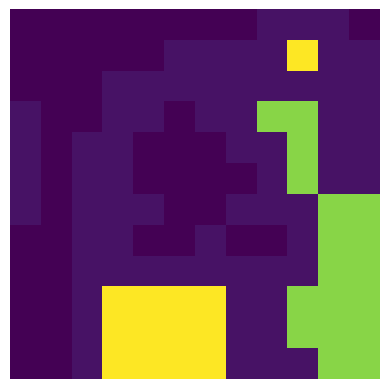

In [6]:
# plot some cost matrices
plt.axis("off")
plt.imshow(costs_train[0])
plt.savefig('.imgs/warcraft_cost_matrix_0.pdf')
plt.close()

plt.axis("off")
plt.imshow(costs_train[27])
plt.savefig('.imgs/warcraft_cost_matrix_1.pdf')
plt.close()

## 2 Data Loader

In [7]:
class mapDataset(Dataset):
    def __init__(self, tmaps, costs, paths):
        self.tmaps = tmaps
        self.costs = costs
        self.paths = paths
        self.objs = (costs * paths).sum(axis=(1,2)).reshape(-1,1)

    def __len__(self):
        return len(self.costs)

    def __getitem__(self, ind):
        return (
            torch.FloatTensor(self.tmaps[ind].transpose(2, 0, 1)/255).detach(), # image
            torch.FloatTensor(self.costs[ind]).reshape(-1),
            torch.FloatTensor(self.paths[ind]).reshape(-1),
            torch.FloatTensor(self.objs[ind]),
        )

In [8]:
# datasets
dataset_train = mapDataset(tmaps_train, costs_train, paths_train)
#dataset_val = mapDataset(tmaps_val, costs_val, paths_val)
dataset_test = mapDataset(tmaps_test, costs_test, paths_test)

In [9]:
# dataloader
batch_size = 70
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
#loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## 3 Neural Network: Truncated Resnet18

Same as previous paper, we used the truncated ResNet18 (first five layers), $50$ epochs with batches of size $70$, learning rate $0.0005$ decaying at the epochs $30$ and $40$, and $n = 1, \sigma = 1$.

### 3.2 Truncated Resnet18

In [10]:
from torchvision.models import resnet18
nnet = resnet18(pretrained=False)
# build new ResNet18 with Max Pooling
class partialResNet(nn.Module):

    def __init__(self, k):
        super(partialResNet, self).__init__()
        # init resnet 18
        resnet = resnet18(pretrained=False)
        # first five layers of ResNet18
        self.conv1 = resnet.conv1
        self.bn = resnet.bn1
        self.relu = resnet.relu
        self.maxpool1 = resnet.maxpool
        self.block = resnet.layer1
        # conv to 1 channel
        self.conv2  = nn.Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1), bias=False)
        # max pooling
        self.maxpool2 = nn.AdaptiveMaxPool2d((k,k))

    def forward(self, x):
        h = self.conv1(x)
        h = self.bn(h)
        h = self.relu(h)
        h = self.maxpool1(h)
        h = self.block(h)
        h = self.conv2(h)
        out = self.maxpool2(h)
        # reshape for optmodel
        out = torch.squeeze(out, 1)
        out = out.reshape(out.shape[0], -1)
        return out

/home/daniel/Research/Implicit-Networks/Environments/fpo-dys-env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/daniel/Research/Implicit-Networks/Environments/fpo-dys-env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### 3.3 Hyperparameters

In [11]:
# number of epochs
epochs = 50
# learning rate
lr = 5e-4
# log step
log_step = 1

## 4 Optimization Model: Linear Programming

In [12]:
import gurobipy as gp
from gurobipy import GRB

from pyepo.model.grb.grbmodel import optGrbModel

class shortestPathModel(optGrbModel):
    """
    This class is optimization model for shortest path problem on 2D grid with 8 neighbors

    Attributes:
        _model (GurobiPy model): Gurobi model
        grid (tuple of int): Size of grid network
        nodes (list): list of vertex
        edges (list): List of arcs
        nodes_map (ndarray): 2D array for node index
    """

    def __init__(self, grid):
        """
        Args:
            grid (tuple of int): size of grid network
        """
        self.grid = grid
        self.nodes, self.edges, self.nodes_map = self._getEdges()
        super().__init__()

    def _getEdges(self):
        """
        A method to get list of edges for grid network

        Returns:
            list: arcs
        """
        # init list
        nodes, edges = [], []
        # init map from coord to ind
        nodes_map = {}
        for i in range(self.grid[0]):
            for j in range(self.grid[1]):
                u = self._calNode(i, j)
                nodes_map[u] = (i,j)
                nodes.append(u)
                # edge to 8 neighbors
                # up
                if i != 0:
                    v = self._calNode(i-1, j)
                    edges.append((u,v))
                    # up-right
                    if j != self.grid[1] - 1:
                        v = self._calNode(i-1, j+1)
                        edges.append((u,v))
                # right
                if j != self.grid[1] - 1:
                    v = self._calNode(i, j+1)
                    edges.append((u,v))
                    # down-right
                    if i != self.grid[0] - 1:
                        v = self._calNode(i+1, j+1)
                        edges.append((u,v))
                # down
                if i != self.grid[0] - 1:
                    v = self._calNode(i+1, j)
                    edges.append((u,v))
                    # down-left
                    if j != 0:
                        v = self._calNode(i+1, j-1)
                        edges.append((u,v))
                # left
                if j != 0:
                    v = self._calNode(i, j-1)
                    edges.append((u,v))
                    # top-left
                    if i != 0:
                        v = self._calNode(i-1, j-1)
                        edges.append((u,v))
        return nodes, edges, nodes_map

    def _calNode(self, x, y):
        """
        A method to calculate index of node
        """
        v = x * self.grid[1] + y
        return v

    def _getModel(self):
        """
        A method to build Gurobi model

        Returns:
            tuple: optimization model and variables
        """
        # ceate a model
        m = gp.Model("shortest path")
        # varibles
        x = m.addVars(self.edges, ub=1, name="x")
        # sense
        m.modelSense = GRB.MINIMIZE
        # constraints
        for i in range(self.grid[0]):
            for j in range(self.grid[1]):
                v = self._calNode(i, j)
                expr = 0
                for e in self.edges:
                    # flow in
                    if v == e[1]:
                        expr += x[e]
                    # flow out
                    elif v == e[0]:
                        expr -= x[e]
                # source
                if i == 0 and j == 0:
                    m.addConstr(expr == -1)
                # sink
                elif i == self.grid[0] - 1 and j == self.grid[0] - 1:
                    m.addConstr(expr == 1)
                # transition
                else:
                    m.addConstr(expr == 0)
        return m, x

    def setObj(self, c):
        """
        A method to set objective function

        Args:
            c (np.ndarray): cost of objective function
        """
        # vector to matrix
        c = c.reshape(self.grid)
        # sum up vector cost
        obj = c[0,0] + gp.quicksum(c[self.nodes_map[j]] * self.x[i,j] for i, j in self.x)
        self._model.setObjective(obj)

    def solve(self):
        """
        A method to solve model

        Returns:
            tuple: optimal solution (list) and objective value (float)
        """
        # update gurobi model
        self._model.update()
        # solve
        self._model.optimize()
        # kxk solution map
        sol = np.zeros(self.grid)
        for i, j in self.edges:
            # active edge
            if abs(1 - self.x[i,j].x) < 1e-3:
                # node on active edge
                sol[self.nodes_map[i]] = 1
                sol[self.nodes_map[j]] = 1
        # matrix to vector
        sol = sol.reshape(-1)
        return sol, self._model.objVal

In [13]:
# init model
grid = (k, k)
optmodel = shortestPathModel(grid)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-22


## 5 Useful Functions

In [14]:
def evaluate(nnet, optmodel, dataloader):
    # init data
    data = {"Regret":[], "Relative Regret":[], "Accuracy":[], "Optimal":[]}
    # eval
    nnet.eval()
    for x, c, w, z in tqdm(dataloader):
        # cuda
        if next(nnet.parameters()).is_cuda:
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # predict
        cp = nnet(x)
        # to numpy
        c = c.to("cpu").detach().numpy()
        w = w.to("cpu").detach().numpy()
        z = z.to("cpu").detach().numpy()
        cp = cp.to("cpu").detach().numpy()
        # solve
        for i in range(cp.shape[0]):
            # sol for pred cost
            optmodel.setObj(cp[i])
            wpi, _ = optmodel.solve()
            # obj with true cost
            zpi = np.dot(wpi, c[i])
            # round
            zpi = zpi.round(1)
            zi = z[i,0].round(1)
            # regret
            regret = (zpi - zi).round(1)
            data["Regret"].append(regret)
            data["Relative Regret"].append(regret / zi)
            # accuracy
            data["Accuracy"].append((abs(wpi - w[i]) < 0.5).mean())
            # optimal
            data["Optimal"].append(abs(regret) < 1e-5)
    # dataframe
    df = pd.DataFrame.from_dict(data)
    # print
    time.sleep(1)
    print("Avg Regret: {:.4f}".format(df["Regret"].mean()))
    print("Avg Rel Regret: {:.2f}%".format(df["Relative Regret"].mean()*100))
    print("Path Accuracy: {:.2f}%".format(df["Accuracy"].mean()*100))
    print("Optimality Ratio: {:.2f}%".format(df["Optimal"].mean()*100))
    return df

In [15]:
def accuracy(predmodel, optmodel, dataloader):
    """
    A function to evaluate model performance with accuracy.
    Writtne by Daniel McKenzie in the style of PyEPO.

    Args:
        predmodel (nn): a regression neural network for cost prediction
        optmodel (optModel): an PyEPO optimization model
        dataloader (DataLoader): Torch dataloader from optDataSet

    Returns:
        float: true regret loss
    """
    # evaluate
    predmodel.eval()
    loss = 0
    optsum = 0
    # load data
    for data in dataloader:
        x, c, w, z = data
        batch_loss = 0
        # cuda
        if next(predmodel.parameters()).is_cuda:
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # predict
        with torch.no_grad(): # no grad
            cp = predmodel(x).to("cpu").detach().numpy()
        # solve
        for j in range(cp.shape[0]):
            # accumulate loss
            batch_loss += calAccuracy(optmodel, cp[j], w[j].to("cpu").detach().numpy(),j)
        loss += batch_loss/cp.shape[0]
    # turn back train mode
    predmodel.train()
    # normalized
    return loss # divide by batch size


def calAccuracy(optmodel, pred_cost, true_sol,idx):
    """
    A function to calculate normalized true regret for a batch

    Args:
        optmodel (optModel): optimization model
        pred_cost (torch.tensor): predicted costs
        true_sol (torch.tensor): true solution

    Returns:
        acc: 1 if true_sol matches that computed using pred_cost to within a small tolerance.
        
    """
    # opt sol for pred cost
    optmodel.setObj(pred_cost)
    sol, _ = optmodel.solve()
    if np.linalg.norm(sol - true_sol)< 1e-4:
        acc = 1
    else:
        acc = 0
    return acc

In [16]:
def plotLearningCurve(loss_log, regret_log, epochs):
    # draw loss during training
    plt.figure(figsize=(8, 4))
    plt.plot(loss_log, color="c")
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlim(-100, len(loss_log)+100)
    plt.xlabel("Iters", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.title("Learning Curve on Training Set", fontsize=12)
    plt.show()
    # draw normalized regret on test
    plt.figure(figsize=(8, 4))
    plt.plot([i*log_step for i in range(len(regret_log))], regret_log, color="royalblue")
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlim(-epochs/50, epochs+epochs/50)
    plt.ylim(0, max(regret_log[1:])*1.1)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Normalized Regret", fontsize=12)
    plt.title("Learning Curve on Test Set", fontsize=12)
    plt.show()

## 6 Training

### 6.1 Baseline
Baseline model: training with binary cross entropy loss of solutions

In [24]:
# init net
nnet = partialResNet(k=12)
# cuda
if torch.cuda.is_available():
    nnet = nnet.cuda()
# set optimizer
optimizer = torch.optim.Adam(nnet.parameters(), lr=lr)

In [25]:
# set loss
bceloss = nn.BCELoss()

In [28]:
# train
loss_log_baseline = []
regret_log_baseline = []
acc_log_baseline = []
epoch_time_log_baseline = []
train_time_baseline = 0
nnet.train()
tbar = tqdm(range(150))
for epoch in tbar:
    start_time_epoch = time.time()
    for x, c, w, z in loader_train:
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        h = nnet(x)
        wp = torch.sigmoid(h)
        loss = bceloss(wp, w) # loss
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # log
        loss_log_baseline.append(loss.item())
        tbar.set_description("Epoch: {:2}, Loss: {:3.4f}".format(epoch, loss.item()))
    
    end_time_epoch = time.time()
    epoch_time = end_time_epoch - start_time_epoch
    train_time_baseline += epoch_time
    epoch_time_log_baseline.append(epoch_time)
    # scheduled learning rate
    if (epoch == 90) or (epoch == 120):
        for g in optimizer.param_groups:
            g['lr'] /= 10

Epoch: 149, Loss: 0.2561: 100%|██████████| 150/150 [04:11<00:00,  1.68s/it]


In [30]:
# Evaluate
print("Test set:")
df_baseline = evaluate(nnet, optmodel, loader_test)
test_acc = accuracy(nnet, optmodel, loader_test)
print(f'True test accuracy is {test_acc}')

Test set:


100%|██████████| 15/15 [00:19<00:00,  1.30s/it]


Avg Regret: 487.8343
Avg Rel Regret: 1911.50%
Path Accuracy: 10.56%
Optimality Ratio: 0.00%
True test accuracy is 0.0


In [31]:
print(train_time_baseline)

251.65759181976318


### 6.4 DBB

DBB model: training with differentiable black-box optimizer and MSE of solutions

In [17]:
# init net
nnet = partialResNet(k=12)
# cuda
if torch.cuda.is_available():
    nnet = nnet.cuda()
# set optimizer
optimizer = torch.optim.Adam(nnet.parameters(), lr=1e-5)
# set stopper
#stopper = earlyStopper(patience=7)

In [20]:
# init dbb
dbb = pyepo.func.blackboxOpt(optmodel, lambd=10, processes=1)
# set loss
class hammingLoss(torch.nn.Module):
    def forward(self, wp, w):
        loss = wp * (1.0 - w) + (1.0 - wp) * w
        return loss.mean(dim=0).sum()
hmloss = hammingLoss()

Num of cores: 1


In [21]:
# train
regret = pyepo.metric.regret(nnet, optmodel, loader_test)
loss_log_dbb = []
regret_log_dbb = [regret]
acc_log_dbb = []
epoch_time_log_dbb = []
train_time_dbb = 0
print(f'regret is {regret}')
tbar = tqdm(range(epochs))
for epoch in tbar:
    nnet.train()
    start_time_epoch = time.time()
    for x, c, w, z in loader_train:
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = nnet(x) # predicted cost
        wp = dbb(cp) # black-box optimizer
        loss = hmloss(wp, w) # loss
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # log
        loss_log_dbb.append(loss.item())
        epoch_time = start_time_epoch - time.time()
        train_time_dbb += epoch_time
        epoch_time_log_dbb.append(epoch_time)

        tbar.set_description("Epoch: {:2}, Loss: {:3.4f}".format(epoch, loss.item()))
    # scheduled learning rate
    if (epoch == int(epochs*0.6)) or (epoch == int(epochs*0.8)):
        for g in optimizer.param_groups:
            g['lr'] /= 10
    if epoch % log_step == 0:
        # log regret
        regret = pyepo.metric.regret(nnet, optmodel, loader_test) # regret on test
        regret_log_dbb.append(regret)
        print(f'regret is {regret}')
        # early stop
        #regret = pyepo.metric.regret(nnet, optmodel, loader_val) # regret on val
        #if stopper.stop(regret):
        #    break

regret is 0.7751119041482185


Epoch:  0, Loss: 16.6667:   2%|▏         | 1/50 [06:41<5:27:50, 401.45s/it]

regret is 0.5111030454320749


Epoch:  1, Loss: 17.4500:   4%|▍         | 2/50 [13:23<5:21:21, 401.69s/it]

regret is 0.5552937460931218


Epoch:  2, Loss: 18.0500:   6%|▌         | 3/50 [20:03<5:14:10, 401.07s/it]

regret is 0.5342175768519373


Epoch:  3, Loss: 18.1143:   6%|▌         | 3/50 [21:10<5:31:45, 423.53s/it]


KeyboardInterrupt: 

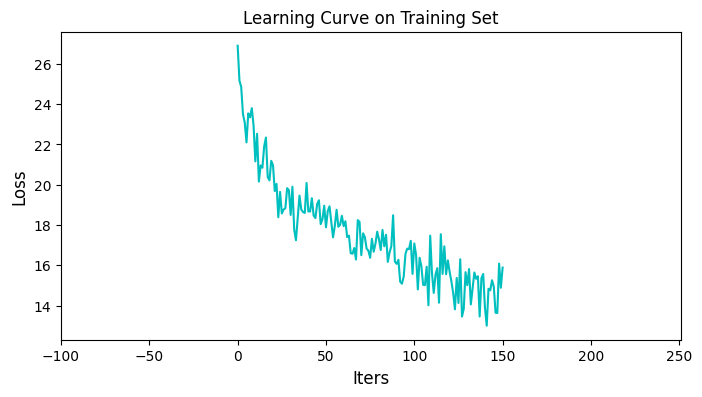

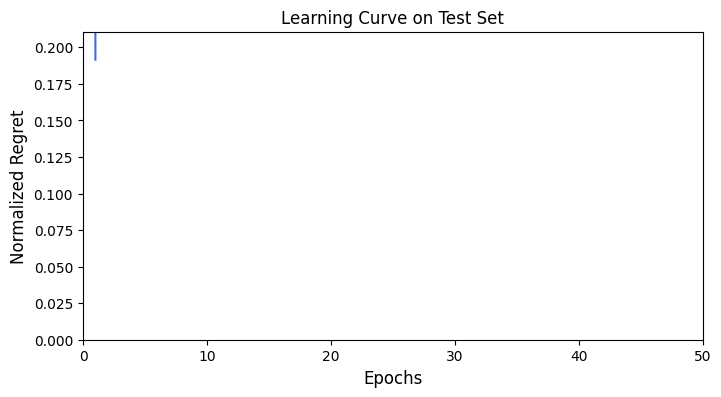

Test set:


 40%|████      | 6/15 [00:08<00:13,  1.48s/it]


KeyboardInterrupt: 

In [ ]:
# plot
plotLearningCurve(loss_log_dbb,  regret_log_dbb)
# eval
print("Test set:")
df_dbb = evaluate(nnet, optmodel, loader_test)
test_acc = accuracy(nnet, optmodel, loader_test)
print(f'True test accuracy is {test_acc}')
print(f'Training time is {train_time_dbb}')


### 6.5 DPO

DPO model: training with differentiable perturbed optimizer and MSE of solutions

In [ ]:
# init net
nnet = partialResNet(k=12)
# cuda
if torch.cuda.is_available():
    nnet = nnet.cuda()
# set optimizer
optimizer = torch.optim.Adam(nnet.parameters(), lr=lr)
# set stopper
#stopper = earlyStopper(patience=7)

In [ ]:
# init dpo
ptb = pyepo.func.perturbedOpt(optmodel, n_samples=1, sigma=1.0, processes=1)
# set loss
mseloss = nn.MSELoss()

Num of cores: 1


In [ ]:
# train
loss_log5, regret_log5 = [], [pyepo.metric.regret(nnet, optmodel, loader_test)]
tbar = tqdm(range(epochs))
for epoch in tbar:
    nnet.train()
    for x, c, w, z in loader_train:
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = nnet(x) # predicted cost
        we = ptb(cp) # perturbed optimizer
        loss = mseloss(we, w) # loss
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # log
        loss_log5.append(loss.item())
        tbar.set_description("Epoch: {:2}, Loss: {:3.4f}".format(epoch, loss.item()))
    # scheduled learning rate
    if (epoch == int(epochs*0.6)) or (epoch == int(epochs*0.8)):
        for g in optimizer.param_groups:
            g['lr'] /= 10
    if epoch % log_step == 0:
        # log regret
        regret = pyepo.metric.regret(nnet, optmodel, loader_test) # regret on test
        regret_log5.append(regret)
        # early stop
        #regret = pyepo.metric.regret(nnet, optmodel, loader_val) # regret on val
        #if stopper.stop(regret):
        #    break

Epoch: 49, Loss: 0.1216: 100%|███████████████████████████████████████████████████████████████████████| 50/50 [3:43:37<00:00, 268.35s/it]


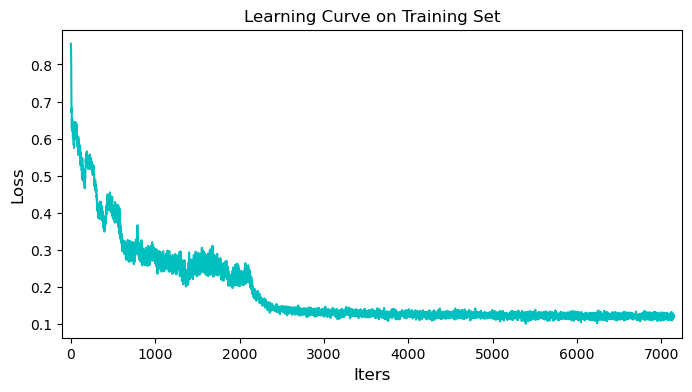

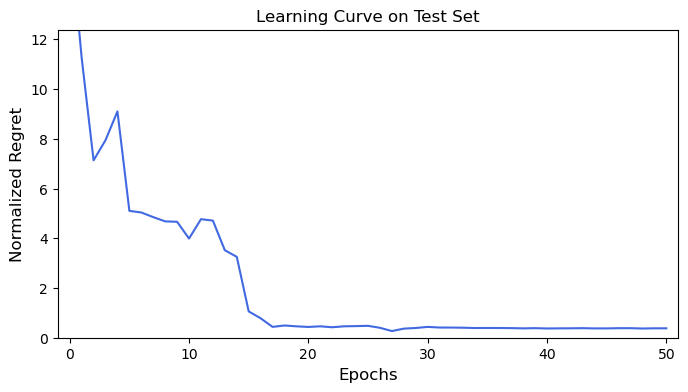

Test set:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:23<00:00,  1.57s/it]


Avg Regret: 11.2376
Avg Rel Regret: 47.51%
Path Accuracy: 88.56%
Optimality Ratio: 7.20%


In [ ]:
# plot
plotLearningCurve(loss_log5, regret_log5)
# eval
print("Test set:")
df5 = evaluate(nnet, optmodel, loader_test)